# Objective of the project:

#### Develop a robust sentiment analysis model specifically focused on financial news using the "financial_phrasebank" dataset also combined one of the other dataset related to finance for getting better understanding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import requests
import string
import gensim
from gensim import corpora
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

In [4]:
train_data = dataset['train']

# Convert to DataFrame
hf_df = train_data.to_pandas()


##### Convert into dataset:

hf_df = pd.DataFrame(hf_df['train'])
hf_df.columns = ['sentence', 'label']

In [5]:
hf_df

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


#### Dataset from kaggle:

In [6]:
kg_df = pd.read_csv('Financial_sentiment_analysis.csv')

In [7]:
kg_df.head(3)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive


In [8]:
#Rename columns in kg_df
kg_df.rename(columns={'Sentence': 'sentence', 'Sentiment': 'label'}, inplace=True)

In [9]:
kg_df['label'].value_counts()

label
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

In [10]:
# Convert label into numeric column in Kg_df:
label_mapping = {'neutral': 1, 'positive': 2, 'negative': 0}

In [11]:
# Apply the mapping
kg_df['label'] = kg_df['label'].map(label_mapping)

#### Combine the 3 dataframes together:

In [12]:
df = pd.concat([hf_df,kg_df], ignore_index=True)

In [13]:
## Reset index
df.reset_index(drop=True, inplace=True)

### Data Cleaning and preprocessing:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10688 entries, 0 to 10687
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10688 non-null  object
 1   label     10688 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 167.1+ KB


##### Handling missing values:

In [15]:
df.columns

Index(['sentence', 'label'], dtype='object')

In [16]:
df.dropna(subset=['sentence'], inplace=True)

#### Text Normalization:

In [17]:
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

In [18]:
df['normalized_sentence'] = df['sentence'].apply(normalize_text)

In [19]:
df['normalized_sentence'][9]

'operating profit totalled eur 211 mn  up from eur 186 mn in 2007  representing 97  of net sales '

#### Tokenization:

In [20]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

In [21]:
df['tokens'] = df['normalized_sentence'].apply(tokenize_text)

#### Stop Word Removal

nltk.download('stopwords')

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

In [24]:
df['filtered_tokens'] = df['tokens'].apply(remove_stop_words)

#### Stemming:

In [25]:
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

In [26]:
df['stemmed_tokens'] = df['filtered_tokens'].apply(stem_tokens)

#### Lemmatization:

nltk.download('wordnet')

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [29]:
df['lemmatized_tokens'] = df['filtered_tokens'].apply(lemmatize_tokens)

## Data Exploration:

 #### (1) Analyze Class Distribution

In [30]:
df['label'].value_counts()


label
1    6009
2    3215
0    1464
Name: count, dtype: int64

In [31]:
class_distribution = df['label'].value_counts(normalize=True)

In [32]:
class_distribution

label
1    0.562219
2    0.300805
0    0.136976
Name: proportion, dtype: float64

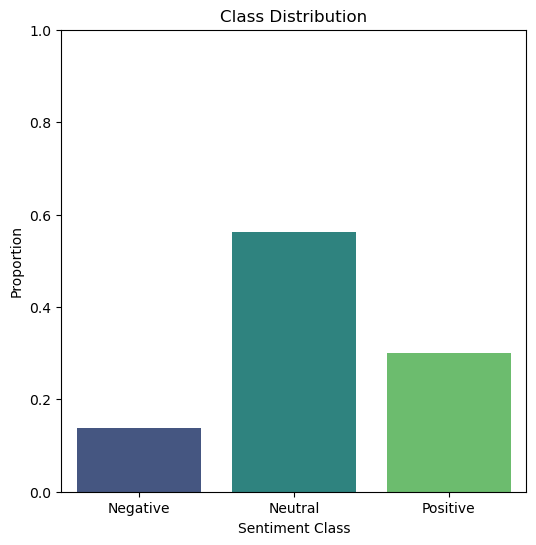

In [33]:
plt.figure(figsize=(6,6))
sn.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Proportion')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.ylim(0.0, 1.0)
plt.show()

###### Class Distribution : Visualizing with the help of bar plot to check the presence of imbalanced data

#### (2) Examine Word Frequency

In [34]:
# function to count the frequency of the words:
def word_freq_by_class(data, label):
    words = [word for tokens in data['lemmatized_tokens'][data['label'] == label] for word in tokens if word not in stop_words]
    return Counter(words).most_common(10)

In [35]:
# Most common words for each sentiment class
negative_words = word_freq_by_class(df, 0)
neutral_words = word_freq_by_class(df, 1)
positive_words = word_freq_by_class(df, 2)

In [36]:
print("Negative words:", negative_words)
print("Neutral words:", neutral_words)
print("Positive words:", positive_words)

Negative words: [('eur', 636), ('mn', 444), ('profit', 319), ('sale', 211), ('net', 204), ('company', 197), ('finnish', 188), ('operating', 186), ('period', 169), ('2009', 165)]
Neutral words: [('company', 1187), ('eur', 778), ('share', 631), ('said', 495), ('finnish', 476), ('sale', 464), ('finland', 442), ('million', 442), ('service', 422), ('business', 393)]
Positive words: [('eur', 885), ('company', 504), ('mn', 480), ('sale', 433), ('said', 424), ('profit', 400), ('net', 393), ('finnish', 375), ('million', 335), ('year', 318)]


###### Word Frequency: By using frequency counts it is really easy to find out common words in each sentiment category.

#### Visualize Data: Word Clouds and Topic Modeling:

In [37]:
# function for generate word cloud for each sentiment
def generate_wordcloud(data, label):
    text = ' '.join([' '.join(tokens) for tokens in data['tokens'][data['label'] == label]])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for ' + str(label))
    plt.show()

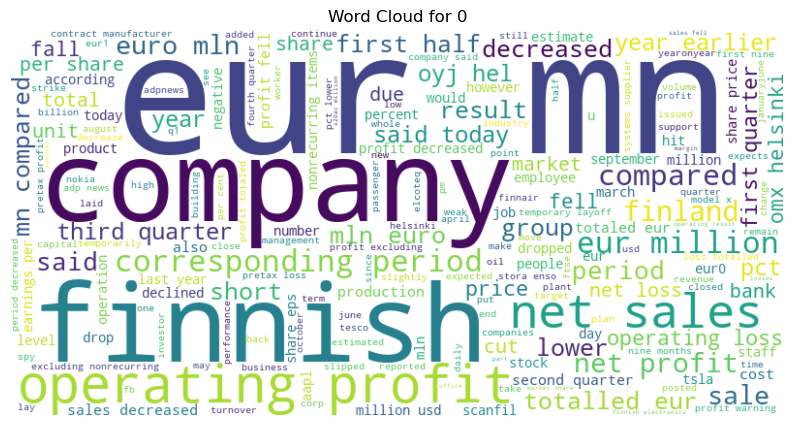

In [38]:
# For negative:
generate_wordcloud(df, 0)  

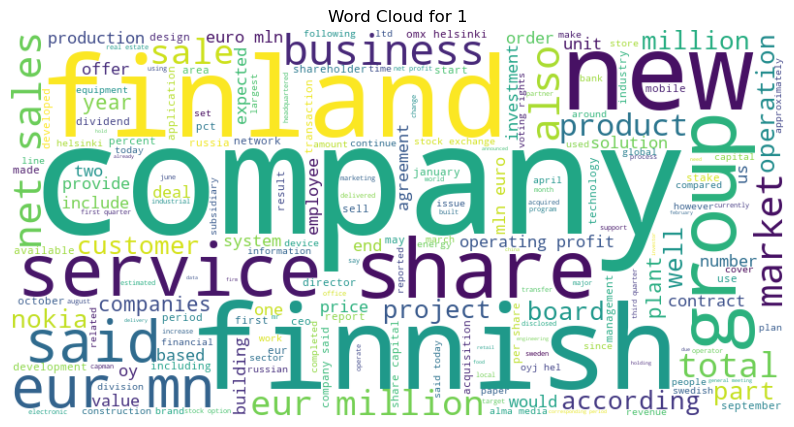

In [39]:
### for neutral:
generate_wordcloud(df, 1) 

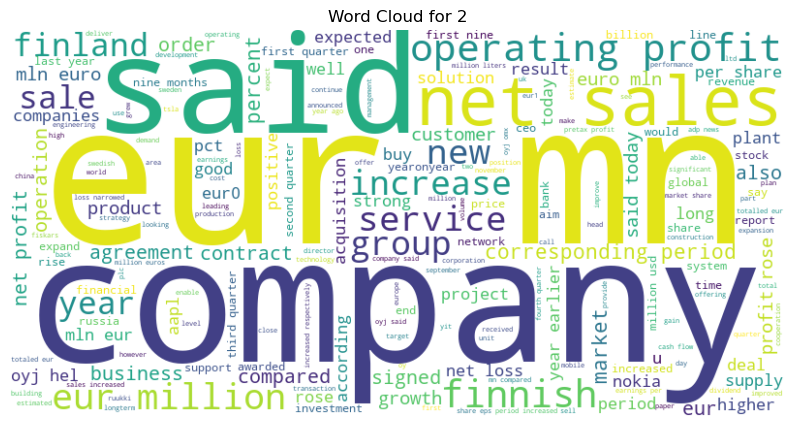

In [40]:
### For positive
generate_wordcloud(df, 2)

##### By visualizing word clouds to indentify common words

#### Topic Modeling:

In [41]:
# Create dictionary and corpus using lemmatized tokens
dictionary = corpora.Dictionary(df['lemmatized_tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['lemmatized_tokens']]

In [42]:
# Build LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

In [43]:
topics = lda_model.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.047*"eur" + 0.026*"mn" + 0.022*"sale"')
(1, '0.009*"company" + 0.007*"said" + 0.005*"business"')
(2, '0.017*"company" + 0.012*"share" + 0.008*"service"')


##### By using the topic modeling helps for deeper insights into the themes

In [44]:
df.columns

Index(['sentence', 'label', 'normalized_sentence', 'tokens', 'filtered_tokens',
       'stemmed_tokens', 'lemmatized_tokens'],
      dtype='object')

## Feature Engineering:

###### (a) n-grams

In [45]:
vectorizer = CountVectorizer(ngram_range=(1, 3))  # Unigrams, bigrams, and trigrams
X_ngrams = vectorizer.fit_transform(df['lemmatized_tokens'].apply(lambda x: ' '.join(x)))

In [46]:
# Get the feature names (n-grams):
feature_names = vectorizer.get_feature_names_out()

In [47]:
# Display the first 10 feature names
print(feature_names[:20])

['00' '00 aldata' '00 aldata 100' '00 compared' '00 compared eur0' '00 mn'
 '00 mn eur' '00 per' '00 per share' '000' '000 2009' '000 2009 lifted'
 '000 85' '000 85 000' '000 company' '000 company added'
 '000 company said' '000 corresponding' '000 corresponding period'
 '000 eur7']


##### (b) Term Frequency-Inverse Document Frequency(TF-IDF)

In [48]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_tokens'].apply(lambda x: ' '.join(x)))

##### (c)Sentiment Lexicons

nltk.download('vader_lexicon')

In [49]:
sia = SentimentIntensityAnalyzer()

In [50]:
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

In [51]:
df['sentiment_scores'] = df['sentence'].apply(analyze_sentiment)

In [52]:
df['positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])

##### Visualize Sentiment Scores:

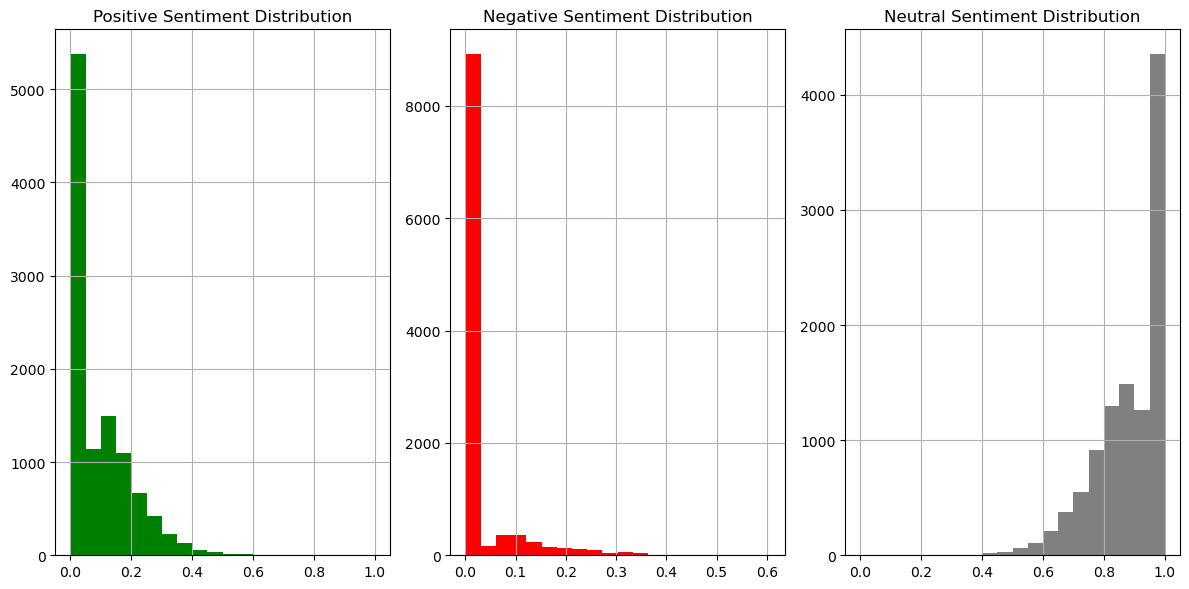

In [53]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
df['positive'].hist(bins=20, color='green')
plt.title('Positive Sentiment Distribution')

plt.subplot(1, 3, 2)
df['negative'].hist(bins=20, color='red')
plt.title('Negative Sentiment Distribution')

plt.subplot(1, 3, 3)
df['neutral'].hist(bins=20, color='gray')
plt.title('Neutral Sentiment Distribution')

plt.tight_layout()
plt.show()

In [54]:
scaler = MinMaxScaler()

##Normalize sentiment score columns
df[['positive_norm', 'negative_norm', 'neutral_norm']] = scaler.fit_transform(df[['positive', 'negative', 'neutral']])

In [55]:
df[['positive_norm', 'negative_norm', 'neutral_norm']].describe()

,positive_norm,negative_norm,neutral_norm
count,10688.000000,10688.000000,10688.000000
mean,0.085883,0.040717,0.889446
std,0.107820,0.109188,0.119406
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.816000
50%,0.043000,0.000000,0.909000
75%,0.151000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [56]:
### Summary statistics:
df[['positive', 'negative', 'neutral']].describe()

,positive,negative,neutral
count,10688.000000,10688.000000,10688.000000
mean,0.085883,0.024674,0.889446
std,0.107820,0.066168,0.119406
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.816000
50%,0.043000,0.000000,0.909000
75%,0.151000,0.000000,1.000000
max,1.000000,0.606000,1.000000


#####  Corrrelation Analysis:

In [57]:
correlation_matrix = df[['positive', 'negative', 'neutral']].corr()
print(correlation_matrix)

          positive  negative   neutral
positive  1.000000 -0.122234 -0.835205
negative -0.122234  1.000000 -0.443723
neutral  -0.835205 -0.443723  1.000000


In [58]:
df['combined_sentiment'] = df[['positive_norm', 'negative_norm', 'neutral_norm']].sum(axis=1)

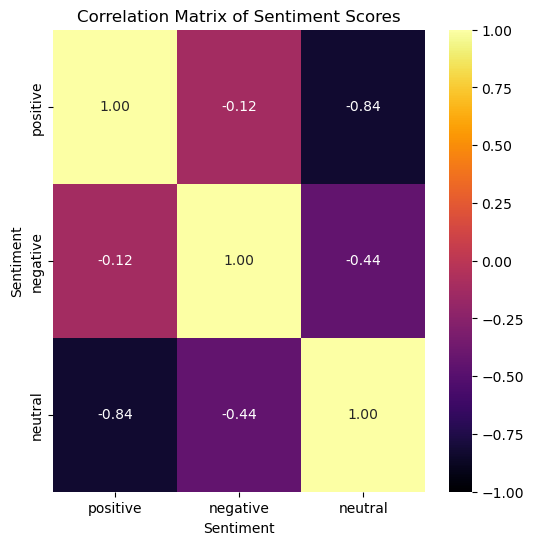

In [59]:
plt.figure(figsize=(6,6))
sn.heatmap(correlation_matrix, annot=True, cmap='inferno', vmin=-1, vmax=1, center=0, fmt='.2f')

# Add title and labels
plt.title('Correlation Matrix of Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Sentiment')

# Show the heatmap
plt.show()

In [60]:
df.columns

Index(['sentence', 'label', 'normalized_sentence', 'tokens', 'filtered_tokens',
       'stemmed_tokens', 'lemmatized_tokens', 'sentiment_scores', 'positive',
       'negative', 'neutral', 'positive_norm', 'negative_norm', 'neutral_norm',
       'combined_sentiment'],
      dtype='object')

In [61]:
df.to_csv('processed_sentiment_data.csv', index=False)

In [62]:
df.shape

(10688, 15)

## Model Selection and Training:

#### Logestic Regression:

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


In [64]:
## Split the dataset:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

In [65]:
lr = LogisticRegression() # Initialize the model
lr.fit(X_train, y_train)  # Fit the model

LogisticRegression()

In [66]:
y_pred = lr.predict(X_test)  # Prediction on test data set:

In [67]:
y_test[4:7]

1523    1
9031    2
346     2
Name: label, dtype: int64

In [68]:
y_pred[4:7]

array([1, 2, 2], dtype=int64)

In [69]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.19      0.25       308
           1       0.71      0.92      0.80      1200
           2       0.94      0.66      0.78       630

    accuracy                           0.74      2138
   macro avg       0.68      0.59      0.61      2138
weighted avg       0.74      0.74      0.72      2138



##### Applying SMOTE to avoid class imbalance

In [70]:
from imblearn.over_sampling import SMOTE

In [71]:
## Apply smote:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [72]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # 'class_weight' can help further
model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [73]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       308
           1       0.85      0.87      0.86      1200
           2       0.88      0.81      0.84       630

    accuracy                           0.82      2138
   macro avg       0.78      0.77      0.77      2138
weighted avg       0.82      0.82      0.82      2138



#### XGBoost

In [74]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [75]:
# Initialize the XG model:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

In [76]:
# defining the hyperparameter grid:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50,100]
}


In [78]:
## fit the model
grid_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=5, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=3, num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100]},
                   verbose=1)

In [81]:
## Predict and evaluate the model
y_pred_xgb = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.60      0.25      0.36       308
           1       0.68      0.93      0.78      1200
           2       0.84      0.48      0.61       630

    accuracy                           0.70      2138
   macro avg       0.71      0.55      0.58      2138
weighted avg       0.72      0.70      0.67      2138



#### SMOTE with XGBoost:

In [82]:
## XGBoost model on the SMOTE-resampled data:

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)


In [83]:
# Fit the model:
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [84]:
## Evaluate and predict the model:
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.56      0.50      0.52       308
           1       0.77      0.86      0.81      1200
           2       0.84      0.69      0.76       630

    accuracy                           0.76      2138
   macro avg       0.72      0.68      0.70      2138
weighted avg       0.76      0.76      0.76      2138



## Conclusion of the project:

In this project, aimed to develop a robust model for financial sentiment analysis, leveraging machine learning techniques to classify sentiments within financial texts. The dataset exhibited significant class imbalance, which posed a challenge for traditional models. To address this, we implemented Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset, ensuring fair representation across all classes.

The model, a Logistic Regression classifier enhanced by SMOTE, demonstrated strong performance across various metrics. The model achieved an overall accuracy of 82%, with macro and weighted F1-scores of 0.77 and 0.82, respectively. These results highlight the model's ability to effectively differentiate between positive, neutral, and negative sentiments, with particularly strong performance in the majority class (Class 1) and commendable balance in the minority classes (Classes 0 and 2).

The use of SMOTE was instrumental in improving the model's performance, particularly in handling the underrepresented classes, leading to a more equitable and accurate classification. This approach not only mitigated the bias towards the majority class but also enhanced the model's generalization ability.


In conclusion, the combination of Logistic Regression and SMOTE has proven to be a robust solution for financial sentiment analysis in imbalanced datasets. The model's strong performance metrics affirm its suitability for real-world applications, where accurate sentiment classification is critical for decision-making in financial contexts. Moving forward, this methodology can be further refined and expanded to incorporate additional features and more complex models, potentially enhancing its predictive power and applicability in diverse financial analysis scenarios.